In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [5]:
max_length = pos_data.shape[1]
def encoder(seq, max_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
# sample unlabeled data
def sample_permutations_from_vec(data_lengths, labeled_unlabeled_ratio=0.2, max_sequence_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    with open("../pdb_dist.txt", 'r') as f:
        # the probabilities in this file are sorted based on the alphabet list above
        pdb_dist = f.read().split()
        pdb_dist = [float(item) for item in pdb_dist]
#     unlabeled_seq_lengths = vec_pep_length(positive_data, ohe_vec=False)
#     print(unlabeled_seq_lengths)
    sampled_lengths = []
    for length in data_lengths:
        length_sample_batch = np.ones(int(1/labeled_unlabeled_ratio), dtype=int) * length
        sampled_lengths.append(length_sample_batch)
    sampled_lengths = np.array(sampled_lengths).flatten()
    sampled_sequences = []
    sampled_vecs = []
    for length in tqdm(sampled_lengths):
#         print(length)
    #         random_alphabet_index = np.random.randint(len(alphabet), size=length)
        # sample alphabet index based on weighted amino acid frequencies in pdb
        random_alphabet_index = np.random.choice(len(alphabet), size=length, p=pdb_dist)
        for _ in range(length):
            pep = ''.join([alphabet[m] for m in random_alphabet_index])
        vec_pep = encoder(pep, max_length=max_length)
        # pad zeros
    #     print(ohe_pep.shape)
#         ohe_pep = np.concatenate([ohe_pep, np.zeros((max_sequence_length-ohe_pep.shape[0],20))],axis=0)
        sampled_vecs.append(vec_pep)
        sampled_sequences.append(pep)
#     sampled_vecs = np.array(sampled_vecs)
    return sampled_sequences, sampled_vecs
# ohe_sequence_list = np.concatenate([ohe_sequence_list, np.zeros((190,10))],axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
labeled_unlabeled_ratio = 0.2
sampled_sequences, sampled_vecs = sample_permutations_from_vec(pos_data_lengths,
                                                               labeled_unlabeled_ratio=0.2, max_sequence_length=max_length)
sampled_vecs = np.array(sampled_vecs)
# X_unlabeled = sampled_vecs
unlabeled_data_lengths = []
for seq in sampled_sequences:
    unlabeled_data_lengths.append(len(seq))

100%|██████████| 9130/9130 [00:00<00:00, 9703.55it/s]


In [6]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_sequences))

Positive data: 1826
Negative data: 7490
Sampled unlabeled data: 9130


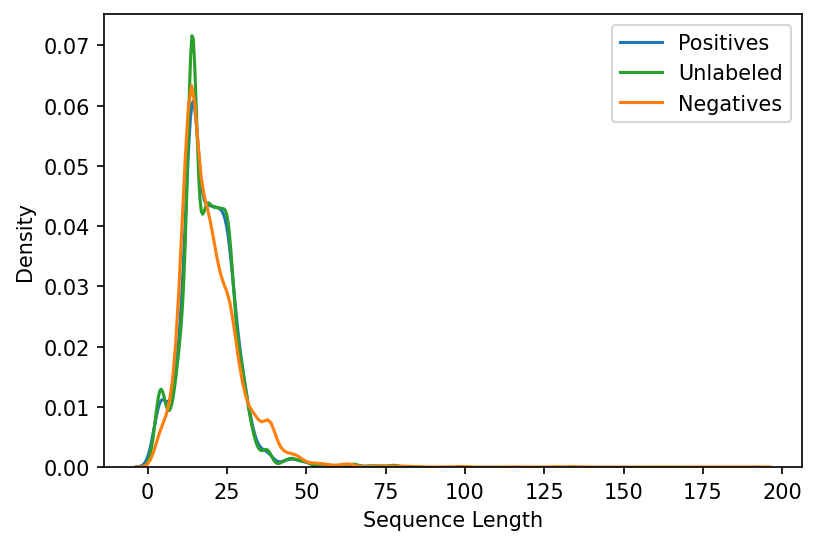

In [7]:
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()

In [8]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[int(index)-1])
  seq = ''.join(seq)
  return seq
# need to decode postive and negative data to get UniRep representations
pos_sequences = []
for f in pos_data:
  pos_sequences.append(decoder(f))

neg_sequences = []
for f in neg_data:
  neg_sequences.append(decoder(f))

In [9]:
# Generating UniRep representations for postives, negatives and unlableled (This cell takes long to run)
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(pos_sequences)
pos_UniRep = h_avg

h_avg, h_final, c_final = get_reps(neg_sequences)
neg_UniRep = h_avg

h_avg, h_final, c_final = get_reps(sampled_sequences)
unlabeled_UniRep = h_avg

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [10]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# kf = KFold(n_splits=5, random_state=None, shuffle=True)
# f1_scores = []
# recall_scores = []
# i = 0

# for train_index, test_index in kf.split(pos_UniRep):
#     X_train_positive_lof, X_test_positive_lof = pos_UniRep[train_index], pos_UniRep[test_index]
# #     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
# #     s_test_positive_svm = y[train_index], y[test_index]
#     s_test_lof = np.ones(X_test_positive_lof.shape[0])
#     lof = LocalOutlierFactor(n_neighbors=64, algorithm='auto',
#                              metric='cosine', contamination=0.01,
#                              novelty=True, n_jobs=20, leaf_size=40)
#     lof.fit(X_train_positive_lof)
# #     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

#     # Make prediction
#     s_pred = lof.predict(X_test_positive_lof)
#     f1 = f1_score(s_test_lof, s_pred, average='macro')
#     r = recall_score(s_test_lof, s_pred, average='macro')
#     print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     f1_scores.append(f1)
#     recall_scores.append(r)
#     i += 1
# #     break
# # lof_f1_score
# lof_f1_score = np.mean(f1_scores)
# lof_recall_score = np.mean(recall_scores)
# print(f'\nMean 5-Fold\n f1 score = {lof_f1_score:.3f}\n recall = {lof_recall_score:.3f}')

In [11]:
def mahalanobis_distance(x, data):
    data = np.unique(data, axis=0)
    x_minus_mu = x - np.mean(data, axis=0, keepdims=True)
    cov = np.cov(data.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = x_minus_mu @ inv_covmat
    mahal = left_term @ x_minus_mu.T
    return mahal.diagonal()
unlabeled_mahal_d = mahalanobis_distance(unlabeled_UniRep, pos_UniRep)
sorted_max_mahal_d_index = np.argsort(unlabeled_mahal_d)[::-1]
outlier_index = sorted_max_mahal_d_index[sorted_max_mahal_d_index[:pos_data.shape[0]]]
initial_RNs = X_unlabeled[outlier_index]

In [12]:
# Shuffling data
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
# shuffled_indices = np.random.permutation(len(sampled_vecs))
# X_unlabeled = sampled_vecs[shuffled_indices]

In [13]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

Now train with found RNs and positives. We do testing and validation based on the known negative data and a small subset of unobserved positives

In [14]:
RNs = initial_RNs
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(RNs.shape[0], dtype=RNs.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, RNs), axis=0)
shuffler = np.random.permutation(len(features))
features = features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)
# add true known negatives to validation and test data
split = X_negative.shape[0]//5 *4
X_negative_val, X_negative_test = X_negative[:split], X_negative[split:]
X_val = np.append(X_val, X_negative_val, axis=0)
y_val = np.append(y_val, np.zeros(X_negative_val.shape[0]), axis=0)
X_test = np.append(X_test, X_negative_test, axis=0)
y_test = np.append(y_test, np.zeros(X_negative_test.shape[0]), axis=0)
shuffler = np.random.permutation(len(X_val))
X_val = X_val[shuffler]
y_val = y_val[shuffler]
shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
y_test = y_test[shuffler]

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                        patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, min_delta=1e-2, restore_best_weights=True)
L = None
tf.keras.backend.clear_session()
model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
decay_epochs = 50
N = len(features)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn, clipnorm=1.0)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])


In [16]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150, batch_size=16)

Epoch 1/150
lr = 0.001
206/206 [==============================] - 36s 78ms/step - loss: 0.1453 - auc: 0.9856 - binary_accuracy: 0.9489 - val_loss: 4.2695 - val_auc: 0.5596 - val_binary_accuracy: 0.0799
Epoch 2/150
lr = 0.0009991954
206/206 [==============================] - 13s 63ms/step - loss: 0.0778 - auc: 0.9938 - binary_accuracy: 0.9769 - val_loss: 4.2698 - val_auc: 0.5625 - val_binary_accuracy: 0.0737
Epoch 3/150
lr = 0.0009967841
206/206 [==============================] - 13s 62ms/step - loss: 0.0673 - auc: 0.9965 - binary_accuracy: 0.9778 - val_loss: 4.8360 - val_auc: 0.5631 - val_binary_accuracy: 0.0955
Epoch 4/150
lr = 0.0009927737
206/206 [==============================] - 13s 62ms/step - loss: 0.0622 - auc: 0.9969 - binary_accuracy: 0.9784 - val_loss: 4.9687 - val_auc: 0.5743 - val_binary_accuracy: 0.0937
Epoch 5/150
lr = 0.0009871772
206/206 [==============================] - 12s 58ms/step - loss: 0.0488 - auc: 0.9971 - binary_accuracy: 0.9851 - val_loss: 5.1927 - val_auc:

50/50 [==============================] - 1s 17ms/step - loss: 4.9581 - auc: 0.5393 - binary_accuracy: 0.0941


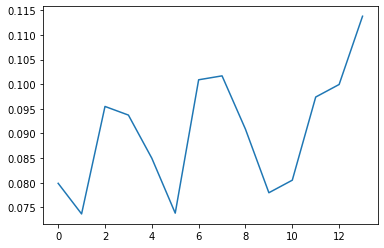

In [17]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

Let's see how the model works with classical positive-negative classification

In [18]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(neg_data.shape[0], dtype=neg_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)

In [19]:
tf.keras.backend.clear_session()
model = build_model(L)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [20]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 0.001
262/262 [==============================] - 19s 44ms/step - loss: 0.4972 - auc: 0.5915 - binary_accuracy: 0.7991 - val_loss: 0.4661 - val_auc: 0.7187 - val_binary_accuracy: 0.7906
Epoch 2/150
lr = 0.0009986986
262/262 [==============================] - 7s 26ms/step - loss: 0.4550 - auc: 0.6962 - binary_accuracy: 0.8012 - val_loss: 0.4415 - val_auc: 0.7760 - val_binary_accuracy: 0.7987
Epoch 3/150
lr = 0.0009948013
262/262 [==============================] - 7s 26ms/step - loss: 0.4430 - auc: 0.7224 - binary_accuracy: 0.8078 - val_loss: 0.4336 - val_auc: 0.7729 - val_binary_accuracy: 0.7987
Epoch 4/150
lr = 0.0009883281
262/262 [==============================] - 7s 26ms/step - loss: 0.4359 - auc: 0.7364 - binary_accuracy: 0.8077 - val_loss: 0.4433 - val_auc: 0.7566 - val_binary_accuracy: 0.7906
Epoch 5/150
lr = 0.000979313
262/262 [==============================] - 7s 26ms/step - loss: 0.4255 - auc: 0.7539 - binary_accuracy: 0.8120 - val_loss: 0.4244 - val_auc: 0.78

6/6 [==============================] - 0s 23ms/step - loss: 0.3933 - auc: 0.8191 - binary_accuracy: 0.8182


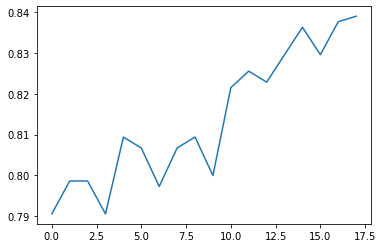

In [21]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()